In [86]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [87]:
input_path = os.path.join(os.getcwd(),'GC_Traffic.txt')
raw_input = pd.read_csv(input_path,sep='\t')
clean_input = raw_input[ ['Date','Transaction Count'] ]
clean_input['date'] = clean_input['Date'].str.replace(' 0:00','')
clean_input['transaction_count'] = clean_input['Transaction Count'].astype(float)
clean_input = clean_input.drop(['Date','Transaction Count'],axis=1)
clean_input['date'] = pd.to_datetime(clean_input['date'],format='%d/%m/%y')
clean_input['date'] = pd.to_datetime(clean_input['date'].dt.strftime('%Y-%m-%d'))
clean_input.to_csv('GC_Traffic.csv',index=False)
clean_input = pd.read_csv('GC_Traffic.csv',index_col=['date'],parse_dates=['date'])
clean_input.head()

,transaction_count
date,
2016-01-01,2093576.000
2016-01-02,2397260.000
2016-01-03,2173039.000
2016-01-04,2051240.000
2016-01-05,1954117.000


In [88]:
clean_input['moving_average_7'] = clean_input['transaction_count'].rolling(window=7).mean()
clean_input['moving_average_14'] = clean_input['transaction_count'].rolling(window=14).mean()
clean_input['moving_average_21'] = clean_input['transaction_count'].rolling(window=21).mean()
clean_input['moving_average_28'] = clean_input['transaction_count'].rolling(window=28).mean()
for i in range(1,7):
    clean_input[f'lag_{i}'] = clean_input['transaction_count'].shift(i)
clean_input['month'] = clean_input.index.month
clean_input['weekend_flag'] = clean_input.index.day_name().isin(['Saturday','Sunday'])
clean_input['growth'] = np.arange(len(clean_input))
clean_input = pd.get_dummies(data=clean_input, columns=['weekend_flag','month']).fillna(0.0)
clean_input.head(10)

,transaction_count,moving_average_7,moving_average_14,moving_average_21,moving_average_28,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,growth,weekend_flag_False,weekend_flag_True,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,2093576.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2016-01-02,2397260.000,0.000,0.000,0.000,0.000,2093576.000,0.000,0.000,0.000,0.000,0.000,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2016-01-03,2173039.000,0.000,0.000,0.000,0.000,2397260.000,2093576.000,0.000,0.000,0.000,0.000,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2016-01-04,2051240.000,0.000,0.000,0.000,0.000,2173039.000,2397260.000,2093576.000,0.000,0.000,0.000,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2016-01-05,1954117.000,0.000,0.000,0.000,0.000,2051240.000,2173039.000,2397260.000,2093576.000,0.000,0.000,4,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2016-01-06,1923592.000,0.000,0.000,0.000,0.000,1954117.000,2051240.000,2173039.000,2397260.000,2093576.000,0.000,5,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2016-01-07,1927622.000,2074349.429,0.000,0.000,0.000,1923592.000,1954117.000,2051240.000,2173039.000,2397260.000,2093576.000,6,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2016-01-08,2074300.000,2071595.714,0.000,0.000,0.000,1927622.000,1923592.000,1954117.000,2051240.000,2173039.000,2397260.000,7,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2016-01-09,2121106.000,2032145.143,0.000,0.000,0.000,2074300.000,1927622.000,1923592.000,1954117.000,2051240.000,2173039.000,8,0,1,1,0,0,0,0,0,0,0,0,0,0,0


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
def timeseries_train_test_split(X, y, test_size):
    test_index = int(len(X)*(1-test_size))
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    return X_train, X_test, y_train, y_test

In [5]:
y = clean_input.fillna(0.0).transaction_count
X = clean_input.fillna(0.0).drop(['transaction_count'],axis=1)
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [6]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

LR: 0.109668 (0.596525)
NN: -0.227974 (1.510443)
RF: 0.220416 (0.350794)
SVR: -0.854820 (0.979860)
KNN: 0.158566 (0.344251)


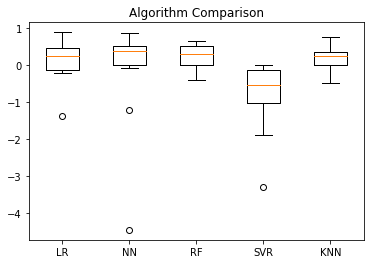

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor()))
models.append(('RF', RandomForestRegressor(n_estimators = 100)))
models.append(('SVR', SVR()))
models.append(('KNN',KNeighborsRegressor()))
results = []
names = []
for name, model in models:
    tscv = TimeSeriesSplit(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [8]:
from sklearn.metrics import make_scorer
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score
rmse_score = make_scorer(rmse, greater_is_better = False)

In [9]:
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)

In [10]:
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [11]:
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.8009
mean_squared_log_error:  0.0164
r2:  0.8006
MAE:  293383.513
MSE:  407689872169.766
RMSE:  638505.9688


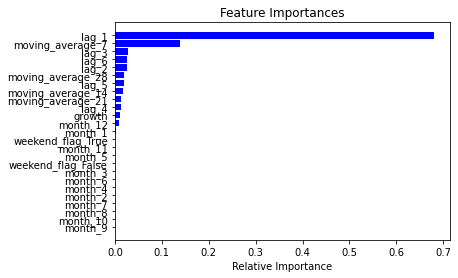

In [12]:
imp = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train_scaled, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [14]:
y_true = y_test.values
y_pred = best_model.predict(X_test_scaled)
regression_results(y_true, y_pred)

explained_variance:  0.8199
mean_squared_log_error:  0.0158
r2:  0.8195
MAE:  281608.1466
MSE:  368894564357.8234
RMSE:  607366.9108


In [52]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotModelResults(model_name,model_object, X_train,X_test,y_train,y_test, plot_intervals, plot_anomalies=False):
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train,cv=tscv,scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error),loc='right')
    plt.title(model_name)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    plt.figure(figsize=(20, 8))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

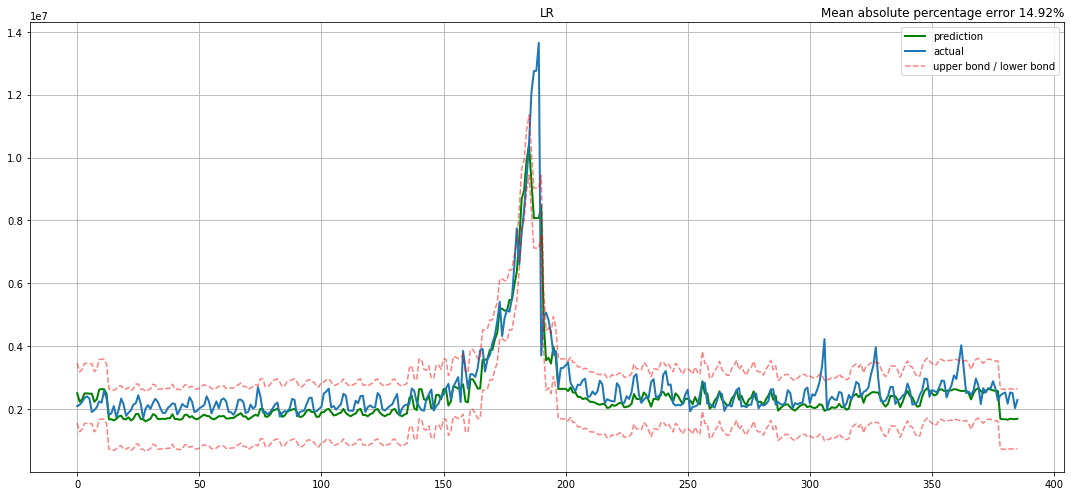

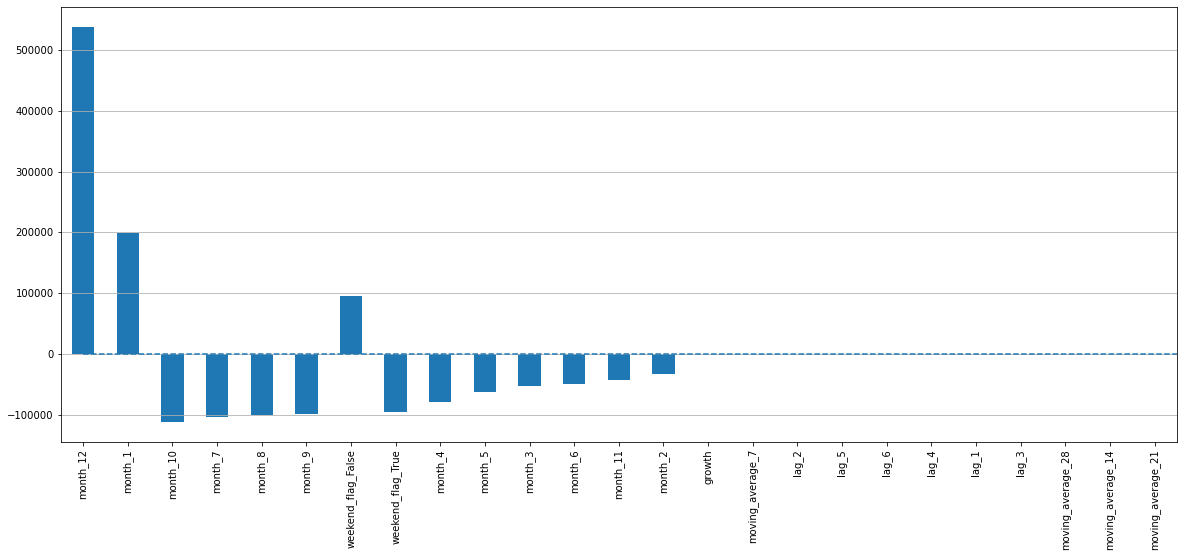

In [79]:
plotModelResults(models[0][0],models[0][1],X_train_scaled, X_test_scaled, y_train, y_test,plot_intervals=True)
plotCoefficients(models[0][1])

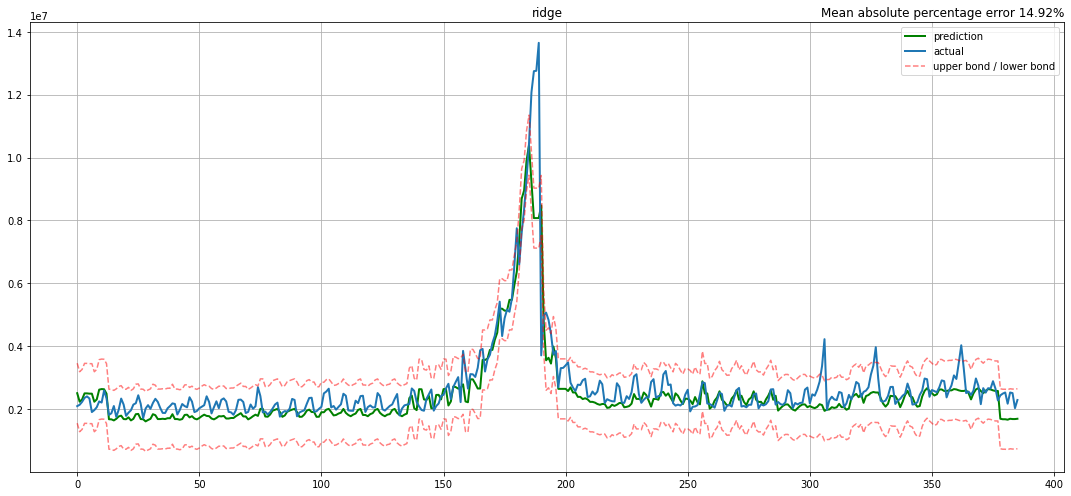

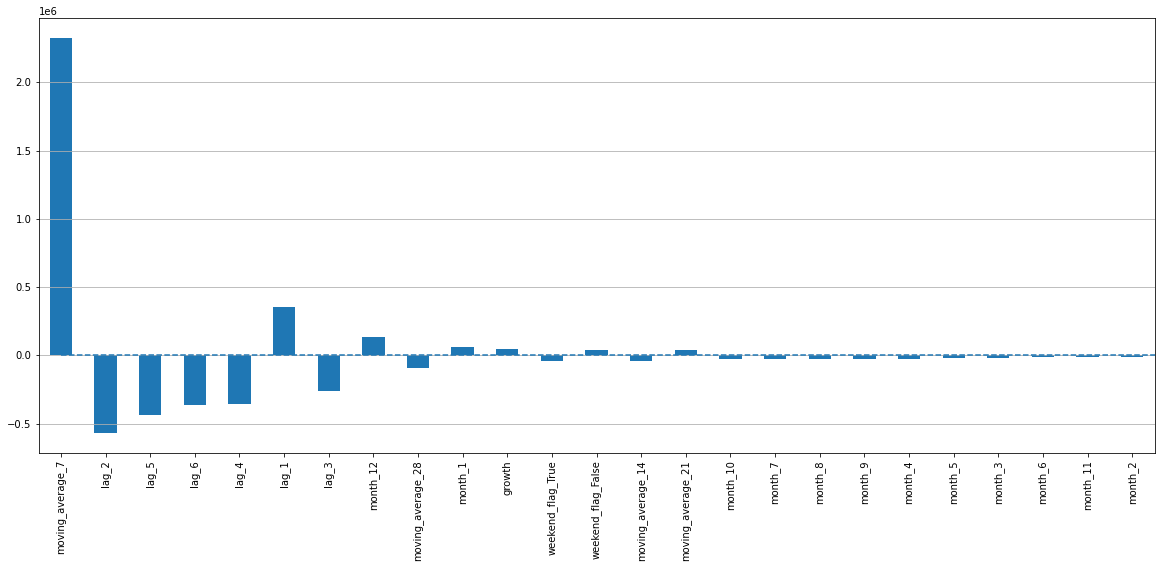

In [80]:
from sklearn.linear_model import LassoCV, RidgeCV
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)
plotModelResults('ridge',ridge,X_train_scaled, X_test_scaled, y_train, y_test,plot_intervals=True)
plotCoefficients(ridge)

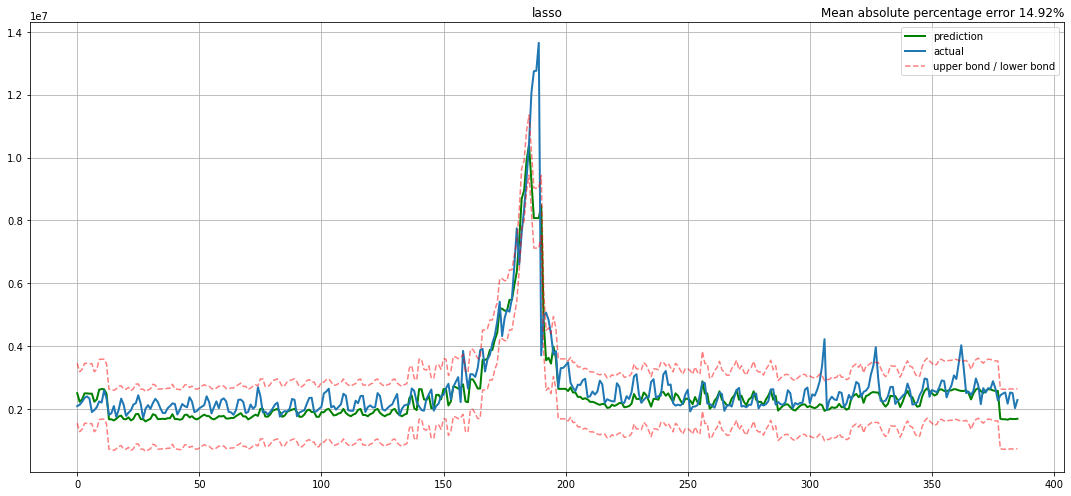

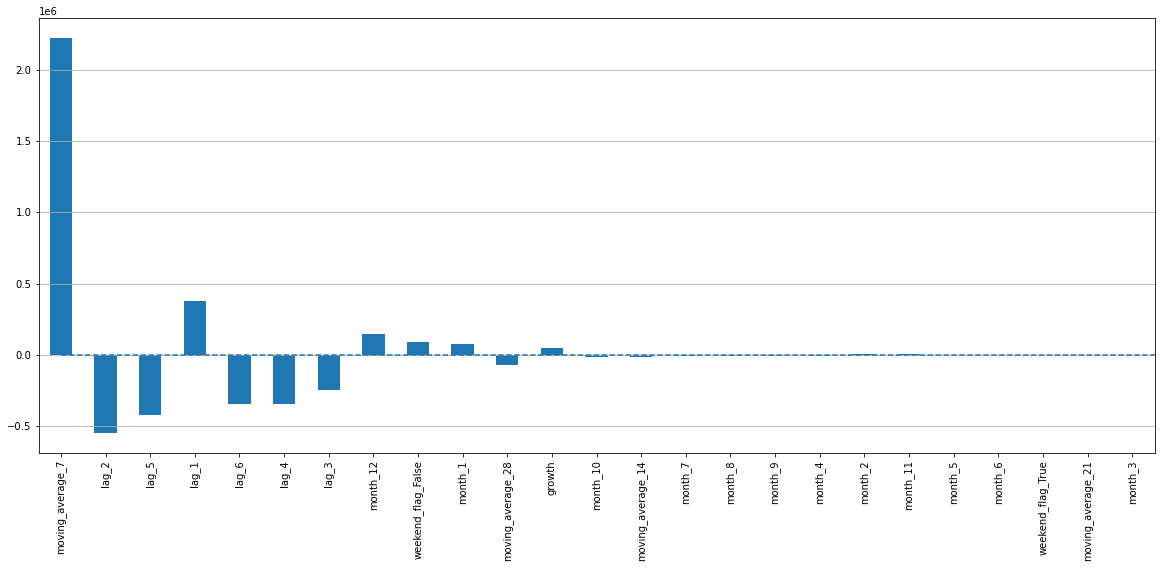

In [82]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)
plotModelResults('lasso',ridge,X_train_scaled, X_test_scaled, y_train, y_test,plot_intervals=True)
plotCoefficients(lasso)

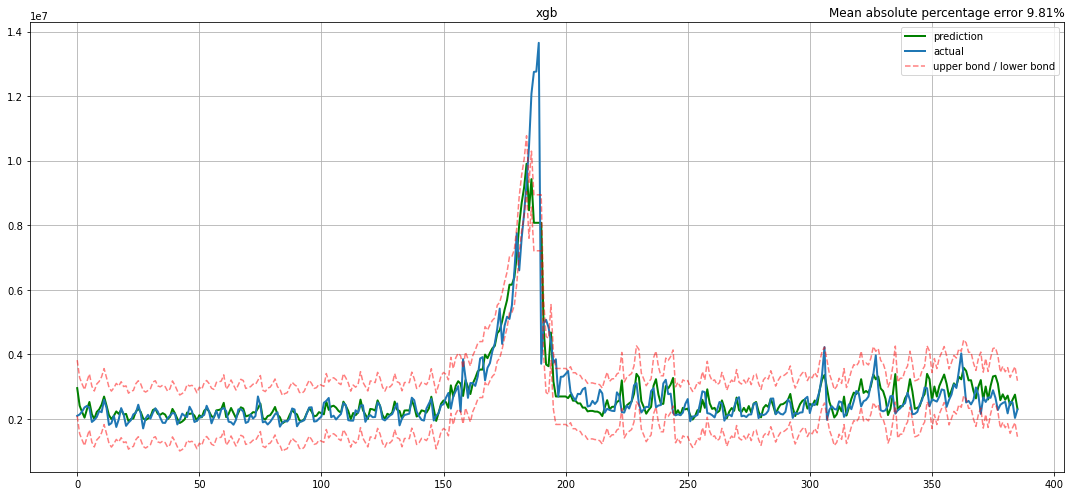

In [84]:
from xgboost import XGBRegressor 
xgb = XGBRegressor()
plotModelResults('xgb',xgb,X_train, X_test, y_train, y_test,plot_intervals=True)